### Import libraries

In [1]:
from classification_header import *

### Import both training and testing data

In [2]:
train_df = pd.read_csv('./train_data_labels.csv')
test_df = pd.read_csv('./test_data.csv')

#### Distribution of Labels

<AxesSubplot:xlabel='count', ylabel='label'>

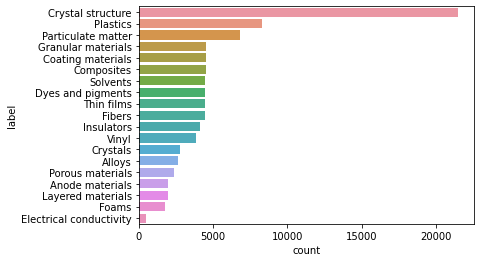

In [4]:
sns.countplot(y = 'label', order = train_df['label'].value_counts().index, data = train_df)

- observe the frequencies of the labels, we can see that
    - the frequency distribution is positively skewed, in other words, the labels are imbalanced
    - crystal structure has an extremely high frequency. this could lead to biased/skewed results of classification models

### Text Preprocessing

- the preprocessing steps are to be carried out for the 'abstract' column in both training and testing dataframes

In [3]:
def preprocess(abstracts):
    def fix_word(word, correction):
        # Pattern: add all the keys to groups in regex, add OR operator '|' in between
        map_pattern = re.compile('({})'.format('|'.join(correction.keys())))
        def match(word):
            w = correction.get(word.group(0)) # group(0) captures the overall match
            return w
        fixed_word = map_pattern.sub(match, word) # Convert the matched token
        return fixed_word
    def remove_web_html(sent):
        # http://\S+|htts://\S+: captures both http & https urls, stop until a space is found
        sent = re.sub('http://\S+|htts://\S+', ' ', sent)
        # Filter out html tagging using beautifulsoup html parser
        return BeautifulSoup(sent, 'html.parser').get_text()
    # Normalize the cases(ensure consistency) and remove numbers(no effect on classification)
    abstracts = abstracts.str.lower().apply(lambda row : row.translate(str.maketrans('', '', string.digits)))
    # Convert various forms of apostrophy to uniform "'", then perform contraction expansion and convert Greek symbols to English
    # This helps reducing syntactic anomalies
    abstracts = abstracts.apply(lambda row : re.sub(r'[`´‘’]{1,}', "'", row))
    abstracts = abstracts.apply(lambda row : ' '.join(fix_word(txt, corrections) for txt in sent_tokenize(row)))
    # Remove HTML tags and WEB links since they do not contain any useful information 
    abstracts = abstracts.apply(lambda row : remove_web_html(row))
    # Remove the remaining punctuations(except whitespace) and remove any multiple whitespaces that were generated
    abstracts = abstracts.str.replace('[^\w\s]', ' ').apply(lambda row : re.sub(r'\s{1, }', ' ', row))
    # Remove abundance stopwords as well as words with length less than 1 since they carry low level information
    abstracts = abstracts.apply(lambda row : ' '.join(w for w in row.split() if len(w) > 1 and not w in stop_words))
    # Lemmatizing the sentences, it is similar to stemming in which it seeks the the root form of the token,
    # however, it does so by discovering the orignal base form of the word in regards to the context, which
    # prevents stemming off any valuable information
    abstracts = abstracts.apply(lambda row : ' '.join(WordNetLemmatizer().lemmatize(w) for w in row.split()))
    return abstracts

In [4]:
train_df['clean'] = preprocess(train_df['abstract'])
test_df['clean'] = preprocess(test_df['abstract'])

#### Remove Duplicated Rows

- there might be some duplicated abstracts in train_df, my approach is to create a dictionary using abstracts as keys and row index as values, so that duplicated abstracts would have more than 1 indexes

In [5]:
length, abstract_map = len(train_df['clean']), {} # Create map to store abstracts
for i in range(length):
    abstract_map[train_df['clean'].iloc[i]] = abstract_map.get(train_df['clean'].iloc[i], list())
    abstract_map[train_df['clean'].iloc[i]].append(i) # Append row indexes of each abstract

- now let's create another dictionary on top of the previous one, still with abstracts as keys, but use a set that stores labels associated with the abstract. The reason is because when a duplicated abstract belongs to different labels, this abstract is of no importance to the later classification

In [6]:
dup = {} # Stores labels as value
for k, v in abstract_map.items(): # Go though each item in the abstract map
    if len(v) < 2: continue # Ignore those unique ones
    dup[k] = dup.get(k, set()) # Use a set for filtering out duplicated labels
    for ind in v: dup[k].add(train_df['label'].iloc[ind])

- finally, we can remove the rows associated with those non important abstracts

In [7]:
ind_to_drop = [] # Stores the row indexes of the non important abstracts
for k, v in dup.items(): # Append row indexes associated with abstracts having more than 1 associated labels
    if len(v) > 1: ind_to_drop += abstract_map[k]
train_df = train_df[~train_df.index.isin(ind_to_drop)] # Drop the selected rows

#### Label Encoding

In [8]:
le = LabelEncoder()
Y = le.fit_transform(train_df['label']) # Fit and encode the strings to numerical values suitable for classifier models
Y_inv = le.inverse_transform(Y) # Retrieve decoded labels for later submission purposes

In [10]:
print_labelmapping(Y, Y_inv)

0: Alloys 1: Anode materials 2: Coating materials 3: Composites 4: Crystal structure 5: Crystals 6: Dyes and pigments 7: Electrical conductivity 8: Fibers 9: Foams 10: Granular materials 11: Insulators 12: Layered materials 13: Particulate matter 14: Plastics 15: Porous materials 16: Solvents 17: Thin films 18: Vinyl 

### Training

- create training and validation sets. Stratify is used to ensure the split sets to preserve the distribution of the orignal set, this is done due to label imbalancing issue, which prevents the split set to contain all samples with the same label

In [9]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(train_df['clean'], Y, test_size = 0.35, random_state=66, stratify = Y)

- TF-IDF
    - key concept is that if a term appears in only a few documents while much frequent in the current document, this docuemnt could be considered dependent on the term, therefore the word gets a higher score. Likewise, if the term appears in most documents but rather rare in any particular document, it gets assigned a low score

In [10]:
# max_df & min_df: words that either occured in over 94% of the texts or occured less than 6 times are to be removed
# token_pattern: extract words only;        strip_accents: normalize any unicode strings;
vectorizer = TV(ngram_range = (1, 2), max_df=0.95, min_df=5, strip_accents='unicode', token_pattern=r'\w{1,}', sublinear_tf=True, norm='l2')
xtrain, xtest = vectorizor_util(Xtrain, Xtest, vectorizer)

In [11]:
label_distribution = Counter(Ytrain)
label_distribution[4] = int(label_distribution[4] * .8)
x_sam, y_sam = NearMiss(sampling_strategy = label_distribution,
                        n_jobs=-1, version=2, n_neighbors = 5).fit_resample(xtrain, Ytrain)

In [12]:
lgb_grid = {'num_leaves':[10,25,31,40],'max_depth':[-1,25,50,100],'subsample':[0.2,0.5,1], 'colsample_bytree':[0.2,0.5,1]}
params = {'objective' : 'multiclassova', 'num_class' : 19, 'metric': 'softmax', 'n_jobs': -1,'verbose': -1}
lgb_opt =  optimal_params(LGBMClassifier(**params), lgb_grid, 'LGB',x_sam,y_sam,xtest,Ytest)

optimal parameters for LGB: {'subsample': 0.5, 'num_leaves': 40, 'max_depth': 50, 'colsample_bytree': 0.5}
cross validation accuracy and validation set accuracy for LGB respectively: 0.812 and 0.829


In [111]:
lsvc = LinearSVC(random_state = 66, max_iter = 3000, C = 0.2)
lsvc.fit(X, Yt)
ypred = lsvc.predict(xtest)
#accuracy_score(Ytest, ypred)

In [109]:
from scipy.sparse import vstack
X = vstack((xtrain, xtest))

In [60]:
Xt = pd.concat([train_df['clean'], test_df['clean']]).reset_index(drop = True)

In [110]:
Yt = np.concatenate((Y, ypred))

In [104]:
params = {'objective' : 'multiclassova', 'num_class' : 19, 'metric': 'softmax', 'n_jobs': -1,'verbose': -1,
         'subsample': 0.5, 'num_leaves': 31, 'colsample_bytree': 0.7, 'max_depth' : 25}
lgb = LGBMClassifier(**params)

In [105]:
lgb.fit(x_sam, y_sam)
Yp = lgb.predict(xtest)

In [106]:
accuracy_score(Ytest, Yp)

0.8262475581601847

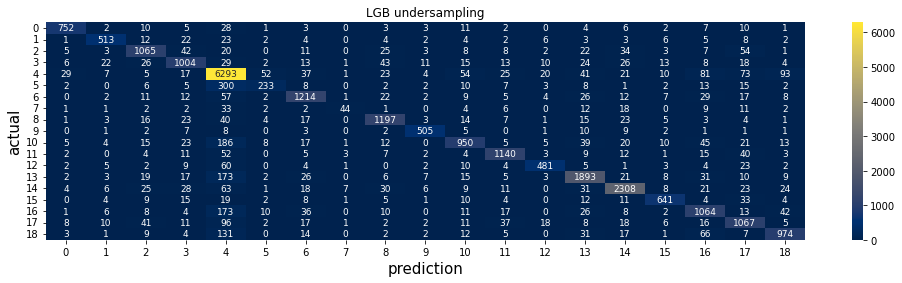

In [13]:
plot_conf(Ytest, lgb_opt.predict(xtest), 'LGB undersampling')

- create an instance of StratifiedKfold(class imbalance) for cross validation

In [19]:
cv = StratifiedKFold(2)

#### LinearSVC

Advantage: very efficient and less prone to outliers since it considers only supporting vectors; allow some misclassifications thus is suitable for linearly inseparable data

Disadvantage: it needs to find a suitable kernel function if the data is non-linearly separable which can be costly(luckly, text classification is generally linearly separable)

#### Gradient Boosting

Advantage: by ensembling many decision trees, the variance is reduced in comparison to use only a single tree, more specifically, the amount of reduction in variance is inversely proportional to the number of trees. Also, gradient boosting methods are proven to be effective for handlation of imbalanced data

Disadvantage: computationally expensive in terms of both training and parameter tuning. Less interpretable of feature interactions, ie. two interactive features could be randomly selected by different learners but not together

In [59]:
# Function for training and evaluating both LinearSVC and LightGBM
def train_n_evaluate():
    lsvc = LinearSVC(random_state = 66, max_iter = 3000) # Create an object instance of LinearSVC model
    lsvc_cvscore = round(cross_val_score(lsvc, xtrain, Ytrain, cv=cv, n_jobs = -1).mean(), 3) # Cross validate LinearSVC
    lsvc.fit(xtrain, Ytrain) # Train LinearSVC
    # Parameters for LightGBM, it uses decision tree as its weak learner
    params = { 'objective' : 'multiclassova','num_class' : 19,'metric': 'softmax','n_jobs': -1,'verbose': -1}
    lgb = LGBMClassifier(**params) # Create an object instance of LightGBM model
    lgb_cvscore = round(cross_val_score(lgb, xtrain, Ytrain, cv=cv, n_jobs = -1).mean(), 3) # Cross validate LightGBM
    lgb.fit(xtrain, Ytrain) # Train LightGBM
    def validate(model): # Prediction on validation set
        ypred = model.predict(xtest)
        return {'result' : round(accuracy_score(Ytest, ypred), 3), 'pred_label' : ypred}
    lsvc_val, lgb_val = validate(lsvc), validate(lgb)
    # Create dataframe that stores the scores for both models
    res = pd.DataFrame(columns = ['cv score', 'validation score'], index = ['L-SVC', 'LGB']) 
    res.loc['L-SVC'] = pd.Series({'cv score' : lsvc_cvscore, 'validation score' : lsvc_val['result']})
    res.loc['LGB'] = pd.Series({'cv score' : lgb_cvscore, 'validation score' : lgb_val['result']})
    # return the resulting dataframe as well as prediction results for both models in a dict
    return {'result' : res, 'L-SVC' : lsvc_val['pred_label'], 'LGB' : lgb_val['pred_label']}

res = train_n_evaluate()

#### Result interpretation

In [61]:
res['result']

,cv score,validation score
L-SVC,0.802,0.813
LGB,0.804,0.819


- without parameter tuning, it can be seen that ensembling method yields a higher accuracy score in terms of either cross validation or validation set.

#### Model Comparison

- confusion matrix provides a comprehensive visual representation on the classifier's performance, with x, y axis being predicted and actual label respectively, and diagonal being the total number of correct predictions for each label

LightGBM Report

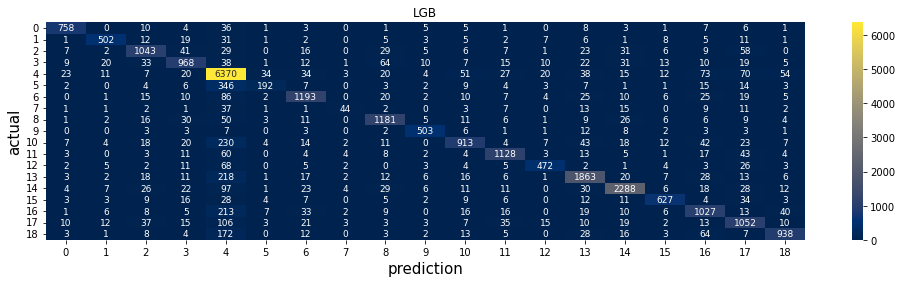

In [133]:
plot_conf(Ytest, res['LGB'], 'LGB')

- from the result, we can see that the model is biased toward 'Crystal structure', ie. highest number of both correct predictions
- type 1 error is along vertical axis, while type 2 error is along horizontal axis. Thus the boosting model has a lot of false positive predictions for 'Crystal structure'. 

LinearSVC Report

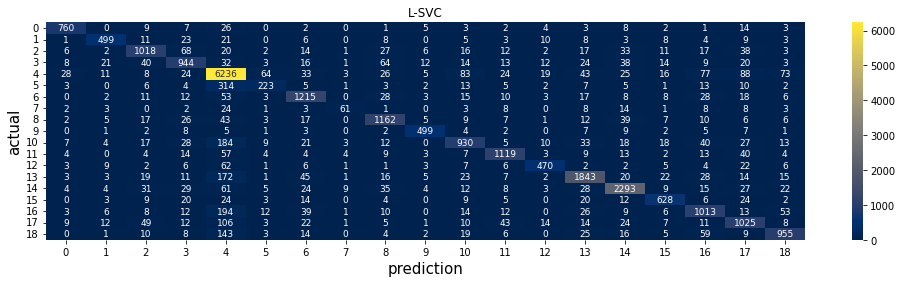

In [134]:
plot_conf(Ytest, res['L-SVC'], 'L-SVC')

- the overall number of correctly predicted labels are approximately the same as LightGBM
- it has a lower number of false positive predictions but higher false negative predictions as comparing with LightGBM

#### Hyperparameter Tuning

In [11]:
# tune C for LinearSVC
lsvc_opt = optimal_params(LinearSVC(random_state=66, max_iter=4500),{'C':[0.1, 0.2, 0.5]},"L-SVC",xtrain,Ytrain,xtest,Ytest)
# tune number of leaf nodes, max depth, training data and feature proportion per tree for LightGBM
lgb_grid = {'num_leaves':[10,25,31,40],'max_depth':[-1,25,50,100],'subsample':[0.2,0.5,1], 'colsample_bytree':[0.2,0.5,1]}
params = {'objective' : 'multiclassova', 'num_class' : 19, 'metric': 'softmax', 'n_jobs': -1,'verbose': -1}
lgb_opt =  optimal_params(LGBMClassifier(**params), lgb_grid, 'LGB',xtrain,Ytrain,xtest,Ytest)

optimal parameters for L-SVC: {'C': 0.2}
cross validation accuracy and validation set accuracy for L-SVC respectively: 0.816 and 0.822
optimal parameters for LGB: {'subsample': 0.2, 'num_leaves': 31, 'max_depth': -1, 'colsample_bytree': 0.5}
cross validation accuracy and validation set accuracy for LGB respectively: 0.813 and 0.821


- a smaller C(allowing a larger margin, thus more misclassifications) is indeed more appropriate for LinearSVC, with a boost in both cross validation accuracy and validation set accuracy
- for LightGBM, the validation accuracy is improved by using a smaller faction of features for each learner, whilst pruning the tree by reducing the maximum depth

Let's take a look at the confusion matrices again

1. Confusion Matrix for LightGBM

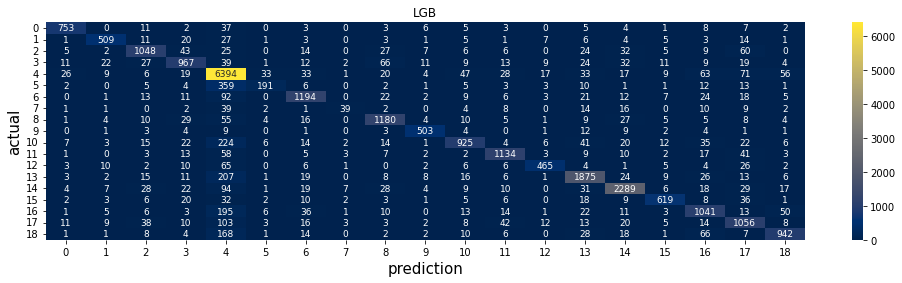

In [12]:
plot_conf(Ytest, lgb_opt.predict(xtest), 'LGB')

- we can see some slight changes in terms of false positive predictions for 'Crystal structure'

2. Confusion Matrix for LinearSVC

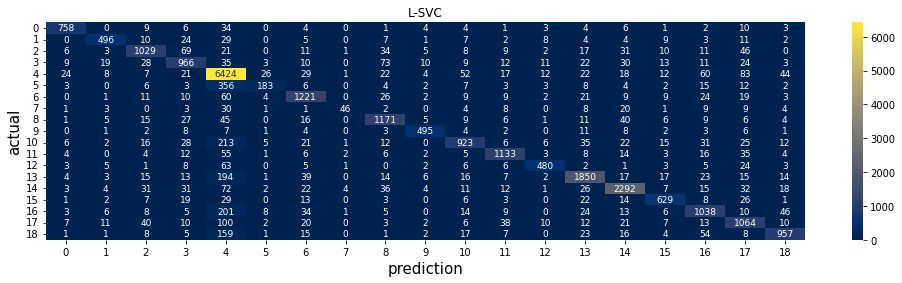

In [13]:
plot_conf(Ytest, lsvc_opt.predict(xtest), 'L-SVC')

- similar to LightGBM, the overall accuracy increases

#### Fix imbalance

- as you can see, imbalance causes the classification model to be biased toward 'Crystal structure' by making a lot of false positive predictions, to fix this, I'll apply undersampling to the majority label using the NearMiss algorithm

In [33]:
ypred_lsvc, ypred_lgb = undersample_cv(lsvc_opt.best_estimator_, 'LSV-C', xtrain, Ytrain, xtest, Ytest), \
                        undersample_cv(lgb_opt.best_estimator_, 'LGB', xtrain, Ytrain, xtest, Ytest)

Best accuracy and best percentage for LSV-C respectively: 0.824 and 0.7000000000000001
Best accuracy and best percentage for LGB respectively: 0.823 and 0.8


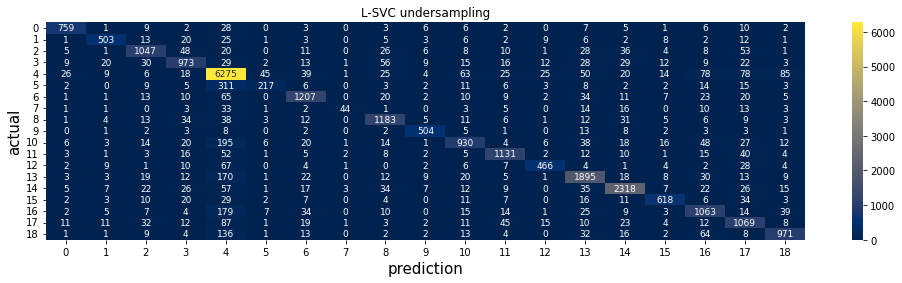

In [34]:
plot_conf(Ytest, ypred_lgb, 'L-SVC undersampling')

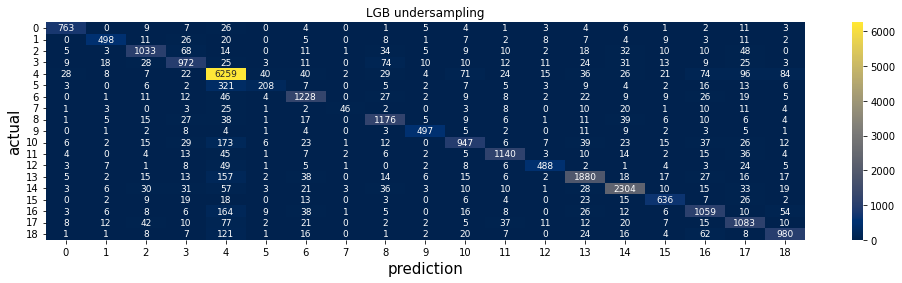

In [35]:
plot_conf(Ytest, ypred_lsvc, 'LGB undersampling')

### Neural Network

Advantage: able to capture hidden complex informations within observations through hidden layers, thus it can handle nonlinearity

Disadvantage: the loss function is typically non-convex, thus the result is likely to be converging to a local minima 

In [52]:
tokenizer = Tokenizer() # Tokenizing the documents
tokenizer.fit_on_texts(list(train_df['clean'])) # Fit on the whole data

In [53]:
xtrain_nn = tokenizer.texts_to_sequences(train_df['clean']) # generate numeric encoding of the tokens
xtest_nn = tokenizer.texts_to_sequences(Xtest)
'''
convert sequence to 2d numpy array with each 1d array having dimension 150
by doing so decrease the time complexity of the NN model
'''
xtrain_nn = pad_sequences(xtrain_nn, maxlen = 150) 
xtest_nn = pad_sequences(xtest_nn, maxlen = 150)
ytrain_nn = pd.get_dummies(Yt).values
ytest_nn = pd.get_dummies(Ytest).values

In [54]:
mat = build_mat(tokenizer.word_index)

In [55]:
from keras.optimizers import adam_v2
def construct():
    _input = Input(shape=(150, ), dtype='int32')
    X = Embedding(*mat.shape, input_length = 150, weights = [mat], trainable = False)(_input)
    X = Bidirectional(GRU(128, return_sequences = True, kernel_initializer=initializers.glorot_normal(seed = 3)))(X)
    X = SpatialDropout1D(0.2)(X)
    X = Bidirectional(GRU(128, return_sequences = True, kernel_initializer=initializers.glorot_normal(seed = 3)))(X)
    X = Conv1D(64, 3, activation="relu")(X)
    X1 = GlobalMaxPool1D()(X)
    X2 = GlobalAveragePooling1D()(X)
    X3 = AttentionWithContext()(X)
    X = concatenate([X1, X2, X3])
    X = BatchNormalization()(X)
    X = Dense(64, activation='relu', kernel_initializer=initializers.glorot_normal(seed = 3))(X)
    X = Dropout(0.1)(X)
    X = Dense(32, activation='relu', kernel_initializer=initializers.glorot_normal(seed = 3))(X)
    _output = Dense(19, activation="softmax")(X)
    model = Model(_input, _output)
    model.compile(loss='categorical_crossentropy', optimizer=adam_v2.Adam(learning_rate=3e-4), metrics=['accuracy'])
    return model
model = construct()

In [116]:
from keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn=construct, epochs=2, batch_size=64)
optimizer = ['SGD', 'RMSprop', 'Adam', 'Adamax']
init = ['glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init=init, optimizer = optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

In [57]:
history = model.fit(xtrain_nn, ytrain_nn, epochs = 8, batch_size = 128, validation_data = (xtest_nn, ytest_nn), 
                    shuffle = True, callbacks=[EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 2)])

Epoch 1/8
629/629 [==============================] - 1082s 2s/step - loss: 2.6812 - accuracy: 0.2486 - val_loss: 2.7025 - val_accuracy: 0.2446
Epoch 2/8
143/629 [=====>........................] - ETA: 12:03 - loss: 2.6374 - accuracy: 0.2573

KeyboardInterrupt: 

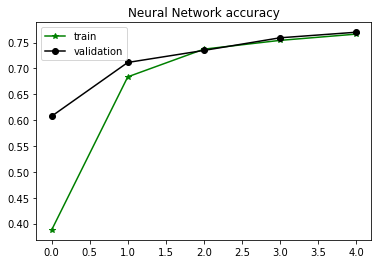

In [51]:
plotnn_train_val(history.history['accuracy'], history.history['val_accuracy'])

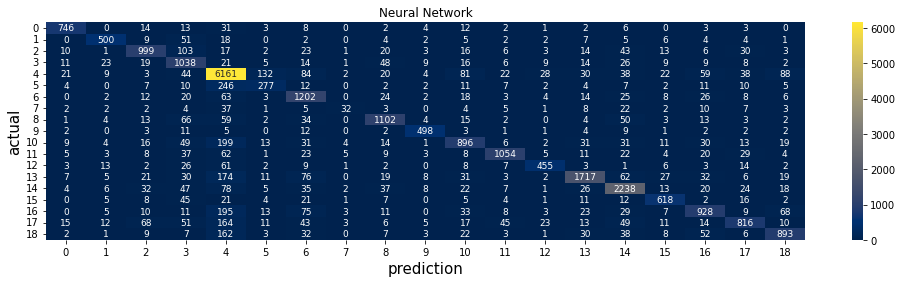

In [19]:
ypred_nn = predict_proba(xtest_nn)
plot_conf(np.argmax(ytest_nn,axis=1), np.argmax(ypred_nn,axis=1), 'Neural Network')

In [ ]:
id = range(1, 10001)
submission = pd.DataFrame({ 'test_id': id,
                            'label': le.inverse_transform(np.argmax(ypred_nn,axis=1))})
submission.to_csv("pred_labels.csv", index=False)